### 사전 훈련된 단어 임베딩 사용

* 구글의 토마스 미코로프 word2vec 알고리즘(https://code.google.com/archive/p/word2vec)
* 스탠포드 대학교 : GloVe(https://nlp.stanford.edu/projects/glove)

### 01 데이터 준비
 * 원본 IMDB 데이터 다운로드
    * http://mng.bz/0tIo에서 다운로드 가능.

In [1]:
import os

imdb_dir = '../data_Imdb'
train_dir = os.path.join(imdb_dir, 'train')

* 데이터 폴더의 neg, pos 폴더의 파일 하나씩을 불러와. 이를 texts에 추가.
* labels에는 긍정인지, 아닌지를 추가

In [2]:
%%time

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Wall time: 3min 52s


### 02 데이터 토큰화

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [4]:
maxlen = 100            # 100개 단어까지 가져오기(뒤에서부터)
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

### 토큰화

In [5]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

88582개의 고유한 토큰을 찾았습니다.


In [6]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [7]:
tr_samples = 200      # 훈련 샘플은 200개입니다
val_samples = 10000  # 검증 샘플은 10,000개입니다

In [8]:
# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

X_train = data[:tr_samples]
y_train = labels[:tr_samples]
X_val = data[tr_samples: tr_samples + val_samples]
y_val = labels[tr_samples: tr_samples + val_samples]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((200, 100), (10000, 100), (200,), (10000,))

### Glove 단어 임베딩 
 * 내려받기 : https://nlp.stanford.edu/projects/glove
    * Download pre-trained word vectors 
    *  Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip 

In [9]:
glove_dir = '../data_Imdb/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


### 임베딩 행렬 만들기

In [10]:
%%time

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector

### 모델 정의하기

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 모델에 GloVe 임베딩 로드하기

*  `Embedding` 층은 하나의 가중치 행렬을 가집니다. 
* 이 행렬은 2D 부동 소수 행렬이고 각 `i`번째 원소는 `i`번째 인덱스에 상응하는 단어 벡터입니다. 
* 모델의 첫 번째 층인 `Embedding` 층에 준비된 GloVe 행렬을 로드

In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 모델 훈련과 평가

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 413ms/step - loss: 2.7089 - acc: 0.4310 - val_loss: 0.6914 - val_acc: 0.5379
Epoch 2/10
7/7 [==============================] - 1s 118ms/step - loss: 0.6269 - acc: 0.6995 - val_loss: 0.7174 - val_acc: 0.5112
Epoch 3/10
7/7 [==============================] - 1s 112ms/step - loss: 0.5734 - acc: 0.6824 - val_loss: 0.6889 - val_acc: 0.5401
Epoch 4/10
7/7 [==============================] - 1s 118ms/step - loss: 0.3894 - acc: 0.8949 - val_loss: 0.7305 - val_acc: 0.5248
Epoch 5/10
7/7 [==============================] - 1s 109ms/step - loss: 0.3574 - acc: 0.8503 - val_loss: 1.0331 - val_acc: 0.4971
Epoch 6/10
7/7 [==============================] - 1s 123ms/step - loss: 0.3719 - acc: 0.8109 - val_loss: 0.6831 - val_acc: 0.5791
Epoch 7/10
7/7 [==============================] - 1s 121ms/step - loss: 0.1354 - acc: 1.0000 - val_loss: 1.0726 - val_acc: 0.5079
Epoch 8/10
7/7 [==============================] - 1s 121ms/step - loss: 0.2905 - acc: 0.85

### 성능 그래프 확인

In [14]:
import matplotlib.pyplot as plt

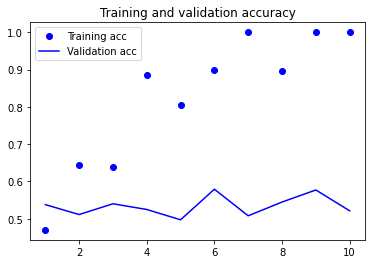

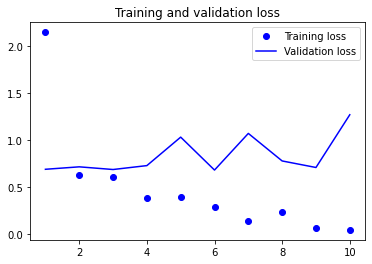

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 03 사전 훈련 모델이 아닌 모델 훈련하여 사용

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 166ms/step - loss: 0.7031 - acc: 0.5174 - val_loss: 0.6915 - val_acc: 0.5126
Epoch 2/10
7/7 [==============================] - 1s 136ms/step - loss: 0.5181 - acc: 0.9803 - val_loss: 0.7007 

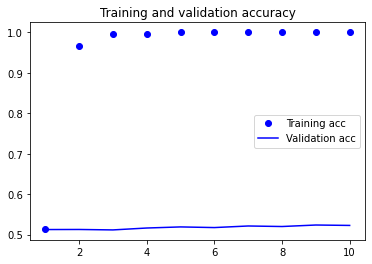

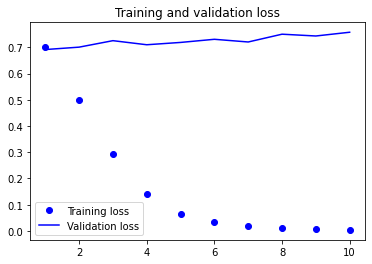

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

훈련샘플을 2000개로 늘려 해보기

In [21]:
tr_samples = 2000      # 훈련 샘플은 200개입니다
val_samples = 10000  # 검증 샘플은 10,000개입니다

In [22]:
training_samples = 2000
X_train = data[:tr_samples]
y_train = labels[:tr_samples]
X_val = data[tr_samples: tr_samples + val_samples]
y_val = labels[tr_samples: tr_samples + val_samples]

In [23]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
63/63 [==============================] - 2s 26ms/step - loss: 0.6389 - acc: 0.6070 - val_loss: 0.6645 - val_acc: 0.6009
Epoch 2/10
63/63 [==============================] - 2s 25ms/step - loss: 0.1819 - acc: 0.9820 - val_loss: 0.6656 - val_acc: 0.6468
Epoch 3/10
63/63 [==============================] - 2s 25ms/step - loss: 0.0262 - acc: 0.9990 - val_loss: 0.6486 - val_acc: 0.6799
Epoch 4/10
63/63 [==============================] - 2s 25ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.6864
Epoch 5/10
63/63 [==============================] - 2s 25ms/step - loss: 2.7420e-04 - acc: 1.0000 - val_loss: 0.7594 - val_acc: 0.6975
Epoch 6/10
63/63 [==============================] - 2s 24ms/step - loss: 1.8904e-05 - acc: 1.0000 - val_loss: 0.7976 - val_acc: 0.7008
Epoch 7/10
63/63 [==============================] - 2s 25ms/step - loss: 2.2578e-06 - acc: 1.0000 - val_loss: 0.8654 - val_acc: 0.7047
Epoch 8/10
63/63 [==============================] - 2s 24ms/step - loss

### 04 마지막으로 테스트 데이터에서 모델 평가

In [24]:
%%time

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Wall time: 12.6 s


### 첫번째 모델 로드 및 평가

In [25]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.2807 - acc: 0.5190


[1.2807399034500122, 0.5189599990844727]

* 테스트 정확도는 겨우 50% 정도입니다. 적은 수의 훈련 샘플로 작업하는 것은 어려운 일